### Imports

In [1]:
%config InlineBackend.figure_format = 'svg'

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle
from models import NonLinearController, ClosedLoopSystem
from Rens import REN_IQC_gamma, DualREN
from utils import set_params, set_QR, ensure_3d
from torch.utils.data import DataLoader, random_split, Subset, SubsetRandomSampler
from ParametersFunctions import Parameter, PID_functions, MinMaxScalerTorch
from pathlib import Path
import scipy.io as sio
from dataset import LoadData

### Set parameters

In [2]:
# Parameters
# ------------
# If ecxecuted with papermill these parameters are overwritten.

patient = globals().get("patient", None)
device = globals().get("device", None)

# if not passed in papermill, set preferred values for manual use
if patient is None:
    patient = 1   # <-- preferred patient for manual use
if device is None:
    device = "cpu"  # <-- preferred device for manual use

# can add like this more optional parameters like batch size, epochs, learning rate, etc.

print(f"[INFO] Training per patient: {patient}    on device: {device}")




# Define simulation parameters
torch.set_default_dtype(torch.float64)

x0, input_dim, output_dim, dim_internal, dim_nl, y_init, IQC_type, gamma, learning_rate, epochs, data_path, model_folder, redo_save, ts, use_noise, num_days = set_params()

[INFO] Training per patient: 1    on device: cpu


# Closed-loop data

In [3]:
#-------------------------2. Generate closed loop data---------------------------------------------


# consecutive days split
train_size = int(num_days*0.8*1440//ts)
val_size = int(num_days*0.1*1440//ts)
test_size = int(num_days*0.1*1440//ts)

start_valid = 5*12 # 5 hours of warm-up for validation and test

# it is normalized, has as method also the scaler to denormalize
dataset = LoadData(patient, data_path, use_noise, train_size+start_valid)


val_dataset   = torch.utils.data.Subset(dataset, range(train_size+start_valid, train_size+start_valid + val_size))
test_dataset  = torch.utils.data.Subset(dataset, range(train_size+start_valid + val_size, train_size + val_size + test_size))

val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)



#------------------------- save scalers ---------------------------------------------------

scaler_glucose = dataset.scaler_glucose
scaler_insulin = dataset.scaler_insulin
scaler_meal    = dataset.scaler_meal

if redo_save:
    # Save the scalers
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save(scaler_glucose, MODEL_PATH / 'scaler_glucose.pth')
    torch.save(scaler_insulin, MODEL_PATH / 'scaler_insulin.pth')
    torch.save(scaler_meal,    MODEL_PATH / 'scaler_meal.pth')
    
    sio.savemat(MODEL_PATH / 'scalers.mat', {
    'glucose_low':  scaler_glucose.params['low'].item(),
    'glucose_high': scaler_glucose.params['high'].item(),
    'insulin_low':  scaler_insulin.params['low'].item(),
    'insulin_high': scaler_insulin.params['high'].item(),
    'meal_low':     scaler_meal.params['low'].item(),
    'meal_high':    scaler_meal.params['high'].item()
})


### Plots: I and R

C:\Users\pmong\OneDrive - Università di Pavia\EPFL\Nonlinear_system_identification_modified\models.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  basal = torch.tensor(basal, dtype=torch.float32)
C:\Users\pmong\OneDrive - Università di Pavia\EPFL\Nonlinear_system_identification_modified\models.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bolus = torch.tensor(bolus, dtype=torch.float32)


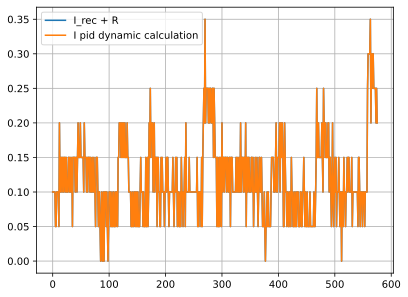

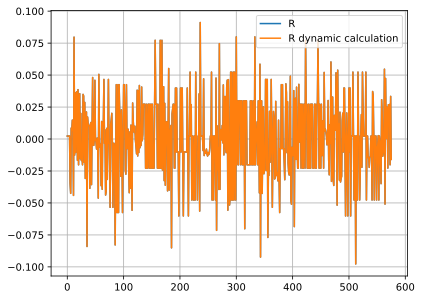

In [4]:
CGM   = (scaler_glucose.denormalize(dataset.CGM.detach())).numpy();              G     = (scaler_glucose.denormalize(dataset.G.detach())).numpy()
                                                                                                                                 
I_sat       = (scaler_insulin.denormalize(dataset.I_sat.detach())).numpy();      I_rec = (scaler_insulin.denormalize(dataset.I_rec.detach())).numpy();       
I_sat_rec   = (scaler_insulin.denormalize(dataset.I_sat_rec.detach())).numpy();  R     = (scaler_insulin.denormalize(dataset.R.detach())).numpy()

M       = (scaler_meal.denormalize(dataset.M.detach())).numpy();                 MH    = (scaler_meal.denormalize(dataset.MH.detach())).numpy();          
MH_rec  = (scaler_meal.denormalize(dataset.MH_rec.detach())).numpy()
H       = (scaler_meal.denormalize(dataset.H.detach())).numpy();                 H_rec = (scaler_meal.denormalize(dataset.H_rec.detach())).numpy();     

# R = I_sat (from .mat) - I_rec (exiting the PID and before saturation and noise)
# if  use_noise = True, R contains the noise and the saturation effect


# ------------------------- PID controller dynamic simulation ---------------------------------------------------
CGM_torch = dataset.CGM
time = dataset.time
loaded_parameters = Parameter(patient)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
u_pid, u_pid_rwgn, u_pid_rwgn_sat, r = controller(CGM_torch, time)


u_pid           = scaler_insulin.denormalize(u_pid.detach())
u_pid_rwgn      = scaler_insulin.denormalize(u_pid_rwgn.detach())
u_pid_rwgn_sat  = scaler_insulin.denormalize(u_pid_rwgn_sat.detach())
r               = scaler_insulin.denormalize(r.detach())

plt.figure()
plt.plot(I_rec[:2*1440//ts]+ R[:2*1440//ts], label= 'I_rec + R')
plt.plot(u_pid_rwgn_sat.numpy()[:2*1440//ts], label = 'I pid dynamic calculation');             plt.legend();plt.grid(True); plt.show()

plt.figure()
plt.plot(R[:2*1440//ts], label= 'R')
plt.plot(r.numpy()[:2*1440//ts], label = 'R dynamic calculation');                             plt.legend();plt.grid(True); plt.show()


### create multiple batches for train

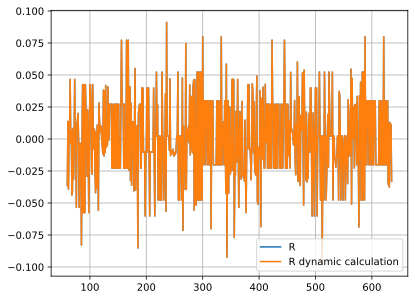

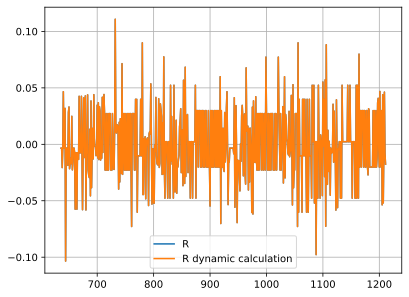

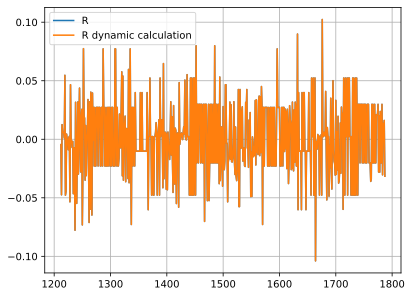

In [5]:
# train ha 5 ore in più
# devo eliminare 5 ore anche dal training se
# recuperare gli starting saturation error aquando taglio i numerosi batch
# provare se plottando batch per volta ottengo stesso risultato
# tagliare ogni due giorni


# time definitions
ts_per_hour = 12           # 288 timesteps = 24h → 12 timesteps/hour (5 min each)
hours_per_batch = 48       # 2 days = 48 hours
steps_per_batch = hours_per_batch * ts_per_hour  # 48*12 = 576

start_train = start_valid        #I eliminate eqully the first 5 hours from training set

train_dataset = torch.utils.data.Subset(dataset, range(start_train, train_size+start_valid))



# === FUNZIONE: crea blocchi fissi ===
def create_fixed_batches(total_length, chunk_size=576, start_idx=0):
    """
    Divide il dataset in batch temporali fissi (48h).
    Ogni batch è una lista di indici consecutivi.
    L'ultimo batch viene scartato se più corto di chunk_size.
    """
    batches = []
    start = start_idx
    while start + chunk_size <= total_length:
        end = start + chunk_size
        batches.append(list(range(start, end)))
        start = end
    return batches


# === COSTRUISCI I BATCH INDICI ===
train_indices = create_fixed_batches(len(train_dataset), chunk_size=steps_per_batch)

starting_indices = [batch[0] for batch in train_indices]

# === CUSTOM SAMPLER ===
class BatchSampler(torch.utils.data.Sampler):
    def __init__(self, batches):
        self.batches = batches

    def __iter__(self):
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)


# === DATALOADER ===
train_loader = DataLoader(
    train_dataset,
    batch_sampler=BatchSampler(train_indices),
    shuffle=False
)

# Se glucose_PID non parte con gli stessi valori della simulazione originale (per esempio primi 5 campioni del batch sono tagliati o glucose_PID è differente), la somma integrale cambia → bolus diverso → R dinamico diverso.

def fun_start_controller(time_batch, loaded_parameters, scaler_glucose, scaler_insulin, CGM):

    previous_starting_index = int(time_batch[0].item())-1

    previous_int_duration = np.arange(previous_starting_index- ((loaded_parameters.PID_par.integral_duration)), previous_starting_index+1)

    if previous_starting_index == 0:
        saturation_error_init = None
    else:
        saturation_error_init = scaler_insulin.denormalize(dataset.sat_e[previous_starting_index])

    if any(previous_int_duration < 0):
        glucose_PID_init = None
    else:
        glucose_PID_init = scaler_glucose.denormalize(CGM[previous_int_duration])


    return saturation_error_init, glucose_PID_init

# === LOOP DI TRAINING ===
for n_batch, (u0_batch, _, _, u1_batch, y_batch, time_batch) in enumerate(train_loader):

    saturation_error_init, glucose_PID_init = fun_start_controller(time_batch, loaded_parameters, scaler_glucose, scaler_insulin, dataset.CGM)

    u_pid, u_pid_rwgn, u_pid_rwgn_sat, r = controller(CGM = y_batch, time = time_batch,
                                                      saturation_error_init = saturation_error_init,
                                                      glucose_PID_init = glucose_PID_init)
    if n_batch < 3:
        r = scaler_insulin.denormalize(r.detach())
        plt.figure()
        plt.plot(time_batch.squeeze().numpy(), R[time_batch.squeeze().numpy().astype(int)], label= 'R')
        plt.plot(time_batch.squeeze().numpy(), r.numpy(), label = 'R dynamic calculation');                             plt.legend();plt.grid(True); plt.show()

### other plots

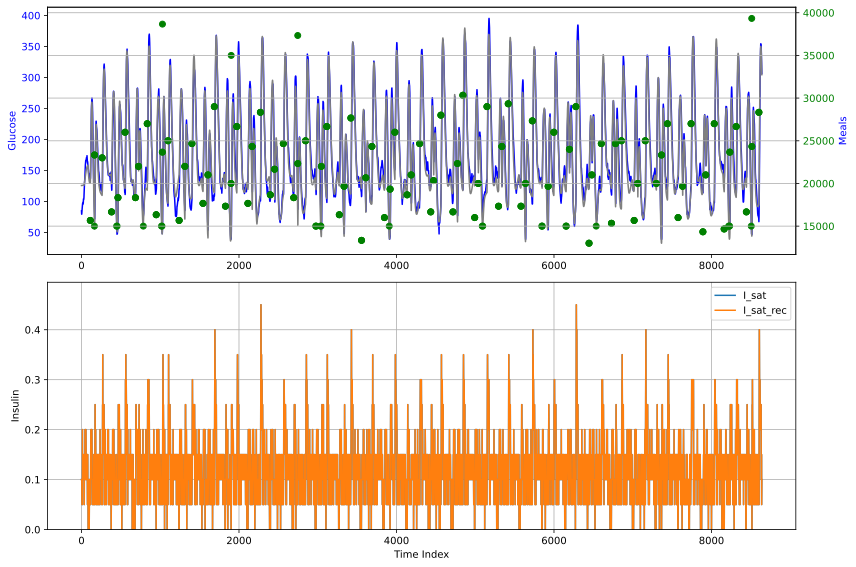

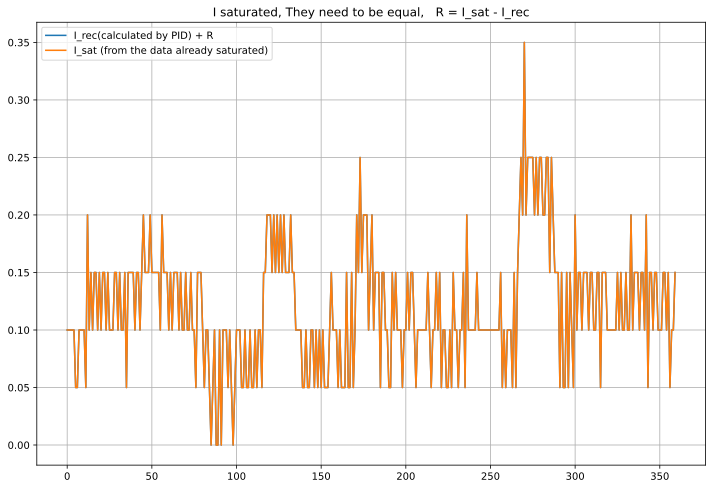

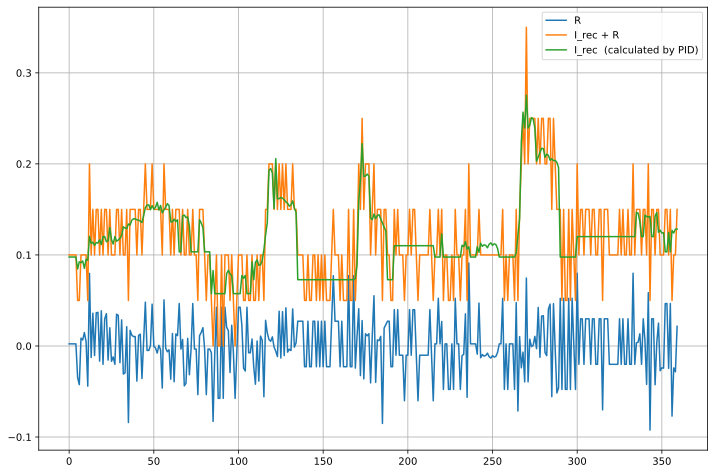

In [6]:
plt.figure(1, figsize=(12, 8))

# Subplot 1
ax1 = plt.subplot(2, 1, 1)
ax1.plot(CGM[:], 'b-', label='Glucose sensor CGM')
ax1.plot(G[:], 'gray', label='Glucose');                                                               ax1.set_ylabel('Glucose', color='b'); ax1.tick_params(axis='y', labelcolor='b'); ax1_right = ax1.twinx()
MHtemp = MH[:].copy()
ax1_right.scatter(np.arange(len(MHtemp))[MHtemp!=0], MHtemp[MHtemp!=0], color='g', label='Meals and hypo');         ax1_right.set_ylabel('Meals', color='b'); ax1_right.tick_params(axis='y', labelcolor='g'); plt.grid(True)

# Subplot 2
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(range(len(I_sat[:])), I_sat[:].flatten(), label='I_sat')
ax2.plot(range(len(I_sat_rec[:])), I_sat_rec[:], label='I_sat_rec');                                      ax2.set_ylim([0, np.max(I_sat_rec) * 1.1]); ax2.legend(); ax2.set_xlabel('Time Index'); ax2.set_ylabel('Insulin')

plt.tight_layout(); plt.grid(True); plt.show()



plt.figure(3, figsize=(12, 8))
plt.plot(I_rec[:1440//4]+ R[:1440//4], label = 'I_rec(calculated by PID) + R')
plt.plot(I_sat[:1440//4], label= 'I_sat (from the data already saturated)')
plt.title('I saturated, They need to be equal,   R = I_sat - I_rec');                   plt.legend();plt.grid(True); plt.show()

plt.figure(4, figsize=(12, 8))
plt.plot(R[:1440//4], label= 'R')
plt.plot(I_rec[:1440//4]+ R[:1440//4], label= 'I_rec + R')
plt.plot(I_rec[:1440//4], label = 'I_rec  (calculated by PID)');                             plt.legend();plt.grid(True); plt.show()


# plt.figure(5)
# plt.plot(H, label='H')
# plt.plot(H_rec-100, label='H_rec')
# plt.title('Hypoglycemia Treatments Comparison');                                                    plt.legend(); plt.show()
#
# plt.figure(6)
# plt.plot(CGM[:1440//4], 'b-', label='Glucose sensor CGM')
# plt.plot(G[:1440//4], 'gray', label='Glucose')
# plt.figure(1, figsize=(12, 8))


# 1 System identification of G

### REN model, loss function and optimizer

In [8]:
#--------------------------3. Define model for sysid---------------------------------------------


device = torch.device(device if torch.cuda.is_available() else "cpu")

# meal   M 
REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

# insulin  I_sat
REN_1 = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)

REN_0 = REN_0.to(device)
REN_1 = REN_1.to(device)

#create the closed loop with the identified model
# closed_loop_G = ClosedLoopSystem(REN_G, controller)

#--------------------------4. Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()

optimizer = torch.optim.Adam( list(REN_0.parameters()) + list(REN_1.parameters()),   lr=learning_rate)
optimizer.zero_grad()

### Training and validation loop

In [9]:
#--------------------------5. Training---------------------------------------------------------------------

torch.set_default_device(device)      # default tensor device
torch.set_default_dtype(torch.float32)  # default tensor dtype
print(f"[INFO] Training on device: {device}")

REN_0.to(device); REN_1.to(device)
train_losses = []
val_losses = []  # Store validation losses across epochs
for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_0.train(); REN_1.train()
    loss_epoch = 0.0  # Accumulate training loss

    
    for u0_batch, _, _, u1_batch, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        
        u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        REN_0.reset(); REN_1.reset()

        y0_hat_train = REN_0(u0_batch) # forward
        y1_hat_train = REN_1(u1_batch) # forward
        y_hat_train = y0_hat_train - y1_hat_train 
        # with monotonicity we have forced a positive response from the insulin REN (REN_1) 
        # but from real-world knowledge it is a negative relation

        loss_batch = MSE(y_hat_train, y_batch)

        loss_batch.backward()
        optimizer.step()
        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_0.eval(); REN_1.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, _, u1_batch, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time

            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch)
            u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
            
            REN_0.reset(); REN_1.reset()

            y0_hat_val = REN_0(u0_batch)
            y1_hat_val = REN_1(u1_batch)# select the correct U
            y_hat_val = y0_hat_val - y1_hat_val
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_REN_0 = REN_0
        candidate_REN_1 = REN_1

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_REN_0_cpu = candidate_REN_0.to('cpu')
    candidate_REN_1_cpu = candidate_REN_1.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_1" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'REN_0_state_dict': candidate_REN_0_cpu.state_dict(),
    'REN_1_state_dict': candidate_REN_1_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})


[INFO] Training on device: cpu
Epoch: 1 	||	 Training Loss: 0.055401 	||	 Validation Loss: 0.051697


### Plots: identification results for G

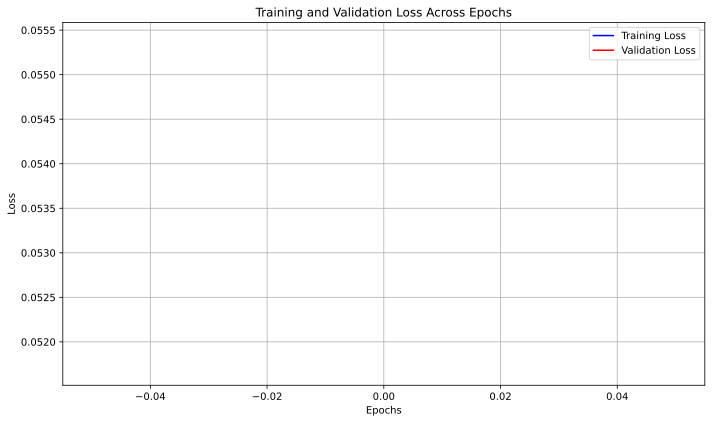

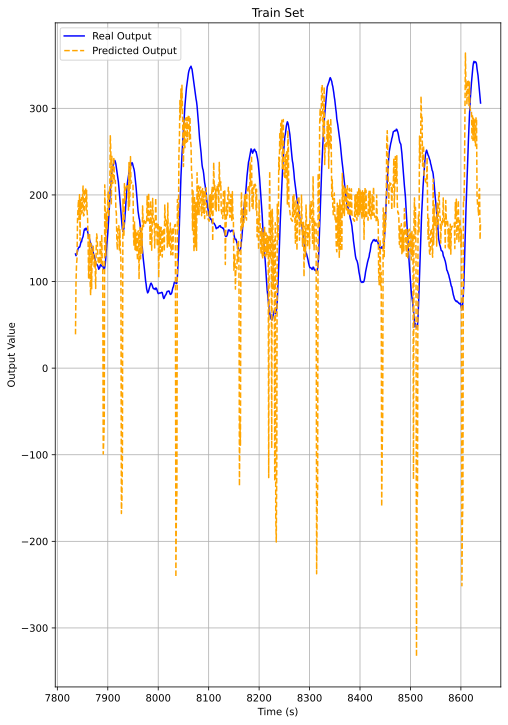

In [10]:
# --------------Plot identification results for G-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)
REN_0.to("cpu"); REN_1.to("cpu")

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time:
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch)
    u0_batch, u1_batch, y_batch = u0_batch.to("cpu"), u1_batch.to("cpu"), y_batch.to("cpu")
    # Plot comparison between real and predicted for training set
    REN_0.eval(); REN_1.eval()

    y0_hat = REN_0(u0_batch)
    y1_hat = REN_1(u1_batch)# select the correct U
    y_hat = y0_hat - y1_hat
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()


# System identification of the negative feedback of K and S

### Closed loop model of REN in negative feedback with K, loss function and optimizer

In [11]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S

y_init = x0


REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

REN_S = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)
Dual_REN = DualREN(REN_0, REN_S, device=device)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
closed_loop_REN = ClosedLoopSystem(Dual_REN, controller, negative=True)

closed_loop_closed_loop_1 = ClosedLoopSystem(closed_loop_REN, controller)



#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam(Dual_REN.parameters(), lr=learning_rate)
optimizer.zero_grad()

### Training and validation loop

In [12]:
#--------------------------5. Training---------------------------------------------------------------------


REN_0 = REN_0.to(device)
REN_S = REN_S.to(device)
Dual_Ren = Dual_REN.to(device)
controller = controller.to(device)
closed_loop_REN = closed_loop_REN.to(device)
x0 = x0.to(device)
print(f"[INFO] Training on device: {device}")

closed_loop_closed_loop_1 = closed_loop_closed_loop_1.to("cpu") # test always on cpu?
torch.set_default_dtype(torch.float32)  # default tensor dtype

train_losses = []
val_losses = []  # Store validation losses across epochs

for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    closed_loop_REN.train()
    loss_epoch = 0.0  # Accumulate training loss


    for u0_batch, _, _, u1_batch, y_batch, t_batch in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        # u_batch.shape = batch_size   horizon   input_dim
        
        u0_batch, u1_batch, y_batch, t_batch = ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch), ensure_3d(t_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch, t_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device), t_batch.to(device)
        u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension

        optimizer.zero_grad()
        
        Dual_REN.reset(); 
        # closed_loop_REN.reset() ?
        
        _, y_hat_train = closed_loop_REN(x0, u_batch, t_batch)

        if torch.isnan(y_hat_train).any() or torch.isinf(y_hat_train).any():
            y_hat_train = torch.nan_to_num(y_hat_train, nan=1e5, posinf=1e5, neginf=-1e5)
            for name, param in closed_loop_REN.named_parameters():
                print(f"{name}: mean {param.data.mean()}, std {param.data.std()}")

        loss_batch = MSE(y_hat_train, y_batch)

        loss_batch.backward()

        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    Dual_REN.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, _, u1_batch, y_batch, t_batch in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
            # u_batch.shape = batch_size   horizon   input_dim
            
            u0_batch, u1_batch, y_batch, t_batch = ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch), ensure_3d(t_batch) # batch_size, time_horizon, input_dim
            u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
            u_batch, y_batch, t_batch = u_batch.to(device), y_batch.to(device), t_batch.to(device)
            
            Dual_REN.reset(); 

            _, y_hat_val = closed_loop_REN(x0, u_batch, t_batch)
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_Dual_REN = Dual_REN

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_Dual_REN_cpu = candidate_Dual_REN.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_2" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'Dueal_REN_state_dict': candidate_Dual_REN_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})

[INFO] Training on device: cpu


C:\Users\pmong\OneDrive - Università di Pavia\EPFL\Nonlinear_system_identification_modified\non_lin_sys_id\lib\site-packages\torch\utils\_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Epoch: 1 	||	 Training Loss: 106.357871 	||	 Validation Loss: 91.833061


### Plots: identification results for the negative feedback of S and K

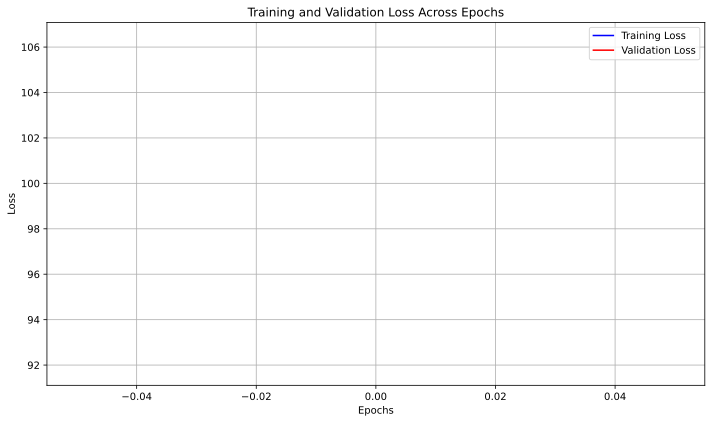

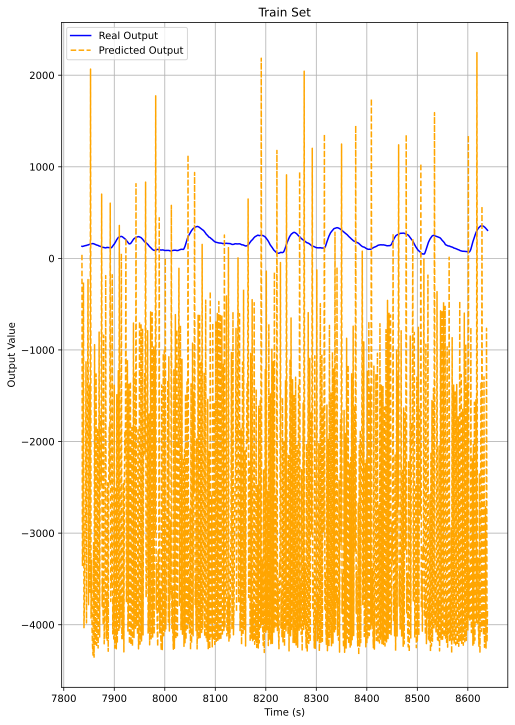

In [13]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

Dual_REN.to("cpu"); closed_loop_REN.to("cpu")
    

for u0_batch, _, _, u1_batch, y_batch, t_batch in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
    # u_batch.shape = batch_size   horizon   input_dim
    
    u0_batch, u1_batch, y_batch, t_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch), ensure_3d(t_batch) # batch_size, time_horizon, input_dim
    u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
    u_batch, y_batch, t_batch = u_batch.to("cpu"), y_batch.to("cpu"), t_batch.to("cpu")
    

    Dual_REN.eval()
    _, y_hat = closed_loop_REN(x0, u_batch, t_batch)
    
    loss_batch_val = MSE(y_batch, y_hat)

    loss_val_epoch += loss_batch_val.item()
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()

# System identification of S using reference inputs

In [14]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S
y_init = x0

REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

REN_S_2 = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)


#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam( list(REN_0.parameters()) + list(REN_S_2.parameters()),   lr=learning_rate)
optimizer.zero_grad()

### Training and validation loop

In [15]:
#--------------------------5. Training---------------------------------------------------------------------

REN_0 = REN_0.to(device)
REN_S_2 = REN_S_2.to(device)
print(f"[INFO] Training on device: {device}")

torch.set_default_dtype(torch.float32)  # default tensor dtype

train_losses = []
val_losses = []  # Store validation losses across epochs


for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_0.train(); REN_S_2.train()
    loss_epoch = 0.0  # Accumulate training loss

    for u0_batch, _, u1_batch, _, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        # u_batch.shape = batch_size   horizon   input_dim
        u0_batch, u1_batch, y_batch = ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)


        optimizer.zero_grad()
        REN_0.reset(); REN_S_2.reset()
        
        
        y0_hat_train = REN_0(u0_batch) # forward
        y1_hat_train = REN_S_2(u1_batch) # forward
        y_hat_train = y0_hat_train - y1_hat_train 
        # with monotonicity we have forced a positive response from the insulin REN (REN_1) 
        # but from real-world knowledge it is a negative relation

        loss_batch = MSE(y_hat_train, y_batch)
        
        loss_batch.backward()
        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_0.eval(); REN_S_2.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, u1_batch, _, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
            # u_batch.shape = batch_size   horizon   input_dim
            
            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
            u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
            
            REN_0.reset(); REN_S_2.reset()
            
            y0_hat_val = REN_0(u0_batch) # forward
            y1_hat_val = REN_S_2(u1_batch) # forward
            y_hat_val = y0_hat_val - y1_hat_val
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_REN_0 = REN_0
        candidate_REN_S_2 = REN_S_2

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_REN_0_cpu = candidate_REN_0.to('cpu')
    candidate_REN_S_2_cpu = candidate_REN_S_2.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_3" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'REN_0_state_dict': candidate_REN_0_cpu.state_dict(),
    'REN_S_2_state_dict': candidate_REN_S_2_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})
    
Dual_REN = DualREN(candidate_REN_0_cpu, candidate_REN_S_2_cpu)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
closed_loop_REN_2 = ClosedLoopSystem(Dual_REN, controller, negative=True)

closed_loop_closed_loop_2 = ClosedLoopSystem(closed_loop_REN_2, controller)

[INFO] Training on device: cpu
Epoch: 1 	||	 Training Loss: 0.191062 	||	 Validation Loss: 0.189885


### Plots: identification results

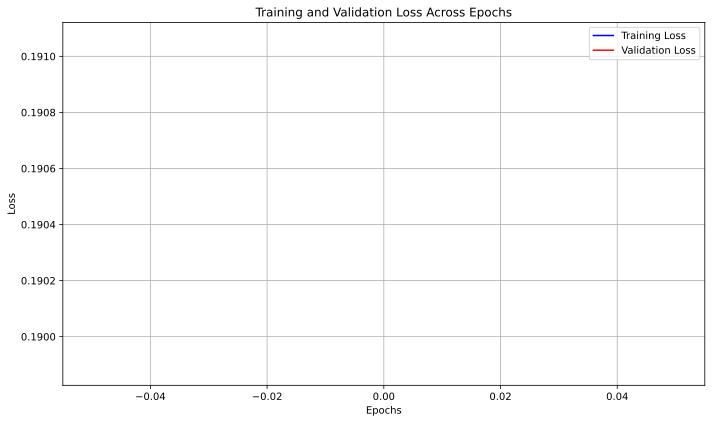

C:\Users\pmong\OneDrive - Università di Pavia\EPFL\Nonlinear_system_identification_modified\non_lin_sys_id\lib\site-packages\torch\utils\_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


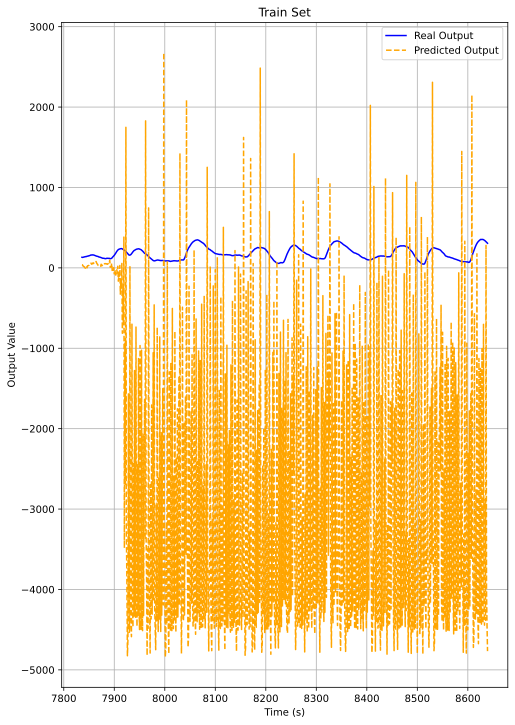

In [16]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

closed_loop_REN_2.to("cpu")

for u0_batch, _, _, u1_batch, y_batch, t_batch in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
    # u_batch.shape = batch_size   horizon   input_dim
    
    u0_batch, u1_batch, y_batch, t_batch = ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch), ensure_3d(t_batch) # batch_size, time_horizon, input_dim
    u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
    u_batch, y_batch, t_batch = u_batch.to("cpu"), y_batch.to("cpu") , t_batch.to("cpu")
    

    closed_loop_REN_2.eval()
    _, y_hat = closed_loop_REN_2(x0, u_batch, t_batch)
    
    loss_batch_val = MSE(y_batch, y_hat)

    loss_val_epoch += loss_batch_val.item()
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()